In [1]:
import silence_tensorflow.auto
import tensorflow as tf
gpuDevices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpuDevices))
tf.config.experimental.set_memory_growth(gpuDevices[0], True)
tf.config.optimizer.set_experimental_options({'layout_optimizer': False})
# tf.config.run_functions_eagerly(True)
# tf.compat.v1.disable_eager_execution()
import keras
import os, sys, random, glob, time, logging, io
from PIL import Image

from IPython import display
import matplotlib.pyplot as plt
import numpy as np

Num GPUs Available:  1


I0000 00:00:1725360050.487379    2812 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725360050.598644    2812 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725360050.602927    2812 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
batch_size = 32
image_shape = (50,200,3)


In [3]:

def decode_one_hot(one_hot_label):
    one_hot_reshaped = tf.reshape(one_hot_label, [6, 10])
    digits = tf.argmax(one_hot_reshaped, axis=-1)
    label = tf.strings.reduce_join(tf.strings.as_string(digits), axis=0)
    return label.numpy()

def plot_ds_unbatched(ds:tf.data.Dataset):
    plt.figure()
    dsit = iter(ds)
    for i in range(9):
        image, label = next(dsit)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"),cmap="gray")
        plt.title(label.numpy())
        plt.tight_layout()
        plt.axis("off")

def plot_ds_batched(ds:tf.data.Dataset):
    plt.figure()
    img_batch,label_batch = next(iter(ds))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img_batch[i].numpy().astype("uint8"),cmap="gray")
        plt.title(decode_one_hot(label_batch[i]))
        
        plt.tight_layout()
        plt.axis("off")



In [4]:
def get_label(file_path: tf.Tensor):
  # print(file_pathx)
  parts = tf.strings.split(file_path, os.path.sep)
  # print(split(parts[-1], ".")[0])
  return tf.strings.split(parts[-1], ".")[0]

In [5]:
def label_to_one_hot(label):
    digits = tf.strings.to_number(tf.strings.unicode_split(label, 'UTF-8'), out_type=tf.int32)
    one_hot_digits = tf.one_hot(digits, depth=10)
    one_hot_label = tf.reshape(one_hot_digits, [-1])
    return one_hot_label



# Unit test:
test_label = tf.constant("123456", dtype=tf.string)
one_hot_result = label_to_one_hot(test_label)
print(one_hot_result.numpy())

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


I0000 00:00:1725360051.090809    2812 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725360051.094448    2812 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725360051.097929    2812 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725360051.239513    2812 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [6]:
def decode_img(img) -> tf.Tensor:
  return tf.io.decode_jpeg(img)

def preprocess_image(image:tf.Tensor) -> tf.Tensor:
  image = tf.cast(image, tf.float32)
  image = tf.image.adjust_contrast(image, 3)
  image =  tf.image.rgb_to_grayscale(image)
  image = tf.divide(tf.cast(image, dtype=tf.float32),tf.constant(255.0, dtype=tf.float32))
  return image

In [7]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [8]:
def process_path(file_path):
  label = get_label(file_path)
  label = label_to_one_hot(label)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = preprocess_image(img)
  return img, label

tf.Tensor(6000, shape=(), dtype=int64)
188


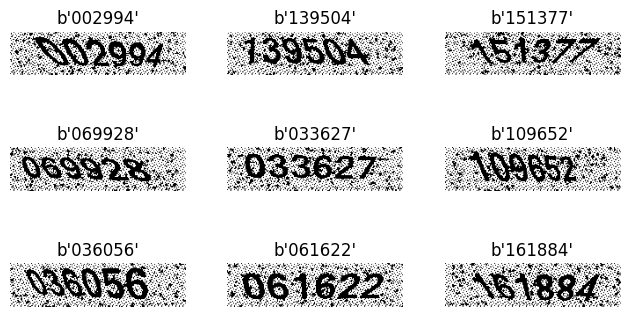

In [9]:
train_ds = tf.data.Dataset.list_files("./data/train/*.jpg", shuffle=False)
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
print(train_ds.cardinality())

train_ds = configure_for_performance(train_ds)
print(train_ds.cardinality().numpy())
plot_ds_batched(train_ds)


In [10]:
def make_encoder() :
    model = keras.Sequential()
    input = keras.layers.Input(shape=(50,200,1))
    model.add(input)
    model.add(keras.layers.Conv2D(128,(3,3), activation='relu', padding='same'))
    assert model.input_shape == (None, 50,200,1)
    
    model.add(keras.layers.MaxPool2D((2,2)))
    model.add(keras.layers.Flatten())

    # print(model.output_shape)

    model.add(keras.layers.Dense(128,activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(64, activation='relu'))

    # print(model.output_shape)    

    # outputs = []
    # for i in range(6):
        # outputs.append(keras.layers.Dense(10, activation='softmax', name=f'digit{i+1}')(model.layers[-1].output))
    # output = keras.layers.Dense(60, activation='softmax')
    # model.add(output)
    # output = keras.layers.Reshape((6,10))(model.layers[-1].output)
    
    # functional_model = keras.Model(inputs=input, outputs=output)
    
    # print (functional_model.output)
    # return functional_model
    model.add(keras.layers.Dense(60, activation='softmax'))
    # model.add(keras.layers.Reshape((6,10)))
    return model

In [11]:
model = make_encoder()

In [12]:
print(model.input_shape)
print(model.output_shape)
input, target = next(iter(train_ds.take(1)))
print(input.shape)
print(target.shape)

(None, 50, 200, 1)
(None, 60)
(32, 50, 200, 1)
(32, 60)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 200, 128)   │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 100, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    40,960,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 60)             │         3,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,973,564 (156.30 MB)

 Trainable params: 40,973,564 (156.30 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer='adam',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [22]:
model.fit(train_ds, epochs=5)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/flatten_1/Reshape defined at (most recent call last):
<stack traces unavailable>
only one input size may be -1, not both 0 and 1

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
File "/home/navid/.pyenv/versions/3.12.5/lib/python3.12/asyncio/base_events.py", line 641, in run_forever
File "/home/navid/.pyenv/versions/3.12.5/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once
File "/home/navid/.pyenv/versions/3.12.5/lib/python3.12/asyncio/events.py", line 88, in _run
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
File "/tmp/ipykernel_2812/2989541657.py", line 1, in <module>
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/layers/layer.py", line 901, in __call__
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/models/sequential.py", line 212, in call
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/models/functional.py", line 175, in call
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/models/functional.py", line 560, in call
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/layers/layer.py", line 901, in __call__
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py", line 54, in call
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 4440, in reshape
File "/home/navid/.pyenv/versions/3.12.5/envs/tf312/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 1789, in reshape

	 [[{{node sequential_1/flatten_1/Reshape}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_5459[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_5526]